# Week Four - Fitting Data: Parameter Estimation Using iminuit

<hr style="border:2px solid gray">

# Outline <a id='outline'></a>
1. [Section One: Interpolation](#section-1)
    1. [Linear Interpolation](#li)
    1. [Cubic Spline](#cs)
1. [Section Two: iminuit](#section-2)
1. [Section Three: Using iminuit](#ui)
    1. [The Basics](#tb)
    1. [Gradient Descent](#gd)
    1. [The Minuit object](#tmo)
    1. [Parameter Uncertainties, Covariances, and Confidence Intervals](#pucaci)
    1. [Maximum-likelihood fits](#mlf)

In data science, you will often be required to fit a curve to a set of data, because you want to interpolate between the data points you have, parameterize it, or extract some physical value from the data you have taken with associated uncertainty. This notebook serves as an introduction to some of these methods.

<hr style="border:2px solid gray">

# Section One: Estimators [^](#index) <a id='im'></a>

### Fundamentals of Fitting

Fitting a model to a set of data is something you have probably encountered dozens of times, albeit this may only be something done implicity. It means finding values of parameters of a chosen model, to best fit a set of data. It is very general and so can be done in a number of ways. It is usually not possible to set your parameters such that a line or curve will fit through all the points but a cost function (which you have seen previously) can be minimised, to optimise the parameters.

The key ingredients for any fit are the following:

* Data,
* A model that you are fitting with certain parameters,
* Initial parameter guesses, 
* An appropriate cost function.

### Estimators

An estimator is simply an estimate for some parameter, using an observed data set. It is necessary for an estimator's value to depend on data observed. Estimators are a **function of random variables** and so the **estimator itself is a random variable** with an expectation and a variance. We will take about the variance of our estimator below when we discuss something called **boostrapping**.

It is not always the case that you will have knowledge of the exact, or even approximate probability distributions for your data. In this case, its extremely difficult to just write down a likelihood and proceed to determine estimates, confidence/credible intervals for various parameters that you might be interested in.

A desireable property for estimators is the larger data set we have, it should converge to the true value of the parameter. Otherwise, the result would be biased in the limit of infinite data. This is the definition of consistent in this context.

### Method of Moments

**The method of moments** is a simple estimator, which is used to estimate parameters of probability densities from observations in data. In this method, we try to match **sample moments** with parameters in the probability density model and use them as estimators of those parameters. To do this, we first need to define the moments of our probability density in terms of its parameters. The simplest way to explain this is with an example

Our estimators are defined by equating the moments of the probability density function with the **sample moments** (sample mean, sample variance, etc). In this example, we'll look at a Gaussian distributed random variable $X\sim\mathcal{N}(3,1.5)$ - i.e $X$ is distributed as a Gaussian with $\mu=3$ and $\sigma=1.5$. 

For a Gaussian, the first moment (the mean) is given by
$$
\mu_{1}  = E[X] = \mu,
$$

and the second moment (variance) is given by, 

$$
\mu_{2} = E[(X-E[X])^{2}]= \sigma^{2}.
$$


Now in general for a sample of $N$ observations, the sample mean is given by 
$$
\bar{X} = \frac{1}{N}\sum_{i=1}^{N} X_{i},
$$

and the sample variance is given by 

$$
\bar{V} = \frac{1}{N}\sum_{i=1}^{N} (X_{i}-\bar{X})^{2}.
$$

In the method of moments then, we equate the sample mean with $\mu_{1}$ and the sample variance with $\nu_{2}$ to obtain our estimates $\hat{\mu}$ and $\hat{\sigma}$, 

$$
\mu = \mu_{1} \implies \hat{\mu} = \bar{X} ,
$$

and 

$$
\sigma^{2} = \nu_{1} \implies \hat{\sigma} = \sqrt{\bar{V}} . 
$$

So to summarise, the method of moments is equating the moments of our probabilty distribution function to the corresponding sample moments. Here is some simple code to show this in action:

In [26]:
import numpy
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams.update({'font.size': 10})


#Defining the mean and standard deviation
mu_true = 3 
sigma_true = 1.5

#Taking 10 samples
nsamples = 10

#Generate random values using rvs
toys = norm.rvs(mu_true, sigma_true, size=nsamples)

#numpy calculation of sample mean
sample_mean = numpy.mean(toys)

#numpy calculation of standard deviation
sample_variance = numpy.std(toys)**2
print(toys)
print("mu_hat = %g, sigma_hat = %g"%(sample_mean,sample_variance**0.5))

[3.17219972 3.31761131 3.76175473 1.86544587 1.37714877 3.4395756
 3.08696218 3.5692026  5.51615849 3.61479049]
mu_hat = 3.27208, sigma_hat = 1.05476


## Section Two: Linear Regression with Least Squares

Linear regression can be used as a simple way to estimate parameters for a model to describe relationships between random variables (and hence observables in datasets). If we divide our variables into two sets $\textbf{X} = (\textbf{X}_{1}, \textbf{X}_{2}, ..., \textbf{X}_n)$ and $y$, we can try to find a relationship between them such that

\begin{equation*}
y = a + \textbf{X} \cdot \textbf{θ},
\end{equation*}

where $a$ and $\textbf{θ} = (θ_{1}, θ_{2}, ..., θ_{n})$ are the parameters of the model. The $\textbf{X}$ are the **independent observables** (sometimes called ‘regressors’), while $y$ is the **dependent observable**.

Linear regression is the process of finding the values of $\textbf{θ}$ and $a$ such that minimises some error function. It is called linear because the equation is *linear* in the *parameters*. We could include terms like the squares of $\textbf{X}$ and the problem would still be linear (as $\textbf{X}$ is not the parameters).

This is often referred to as the **ordinary least-squares solution** to linear regression.
It is a very simple and powerful way to estimate simple linear relationships between pairs of
variables. Let’s take a look at this method in action in an example.

<div style="background-color:#FFCCCB">

### Mathematics of Least Squares

Typically, we have data $\{\textbf{X}_{i}, y_{i}\}_{i=1}^{N}$. One common approach is then to define the cost function

\begin{equation*}
s=\sum_{i=1}^{N}||\mathbf{X_{i}}\cdot\mathbf{θ}+\mathbf{a}-y_{i}||^{2},
\end{equation*}

where $||\textbf{k}||^{2}=\textbf{k}\cdot \textbf{k} = k_{1}^{2}+k_{2}^{2}+...+k_{n}^{2}$. We then minimise the function with respect to the parameters of θ and $c$ such that $ds = 0$. 

To simply things, lets take the case where we only have one independent observable ($X$) so we only have $X$ and $Y$. Then we only have one parameter in the vector θ - let’s call it $b$ - and we can write,

\begin{equation*}
s=\sum_{i=1}^{N}(bX_{i}+a-Y_{i})^{2},
\end{equation*}

and we have two equations to solve by minimising $s$:

\begin{equation*}
\frac{\partial s}{\partial b} = b\sum_{i=1}^{N}X_{i}^{2}+a\sum_{i=1}^{N}X_{i}-\sum_{i=1}^{N}X_{i}Y_{i}=0,
\end{equation*}

and

\begin{equation*}
\frac{\partial s}{\partial a} = b\sum_{i=1}^{N}X_{i}+a\sum_{i=1}^{N}1-\sum_{i=1}^{N}Y_{i}=0.
\end{equation*}

From the expression for $\partial s/\partial a$ we find

\begin{equation*}
a=\frac{1}{N}\left(\sum_{i=1}^{N}Y_{i}-b\sum_{i=1}^{N}X_{i}\right),
\end{equation*}

and substituting this into the equation for $\partial s/\partial b$ gives us,

\begin{equation*}
b\left[N\sum_{i=1}^{N}X_{i}^2-\left(\sum_{i=1}^{N}X_{i}\right)^2 \right] =\sum_{i=1}^{N}X_{i}Y_{i} -\sum_{i=1}^{N}X_{i}\sum_{i=1}^{N}Y_{i},
\end{equation*}

or, re-arranging:
\begin{equation*}
b=\frac{\sum_{i=1}^{N}X_{i}Y_{i} -\sum_{i=1}^{N}X_{i}\sum_{i=1}^{N}Y_{i}}{N\sum_{i=1}^{N}X_{i}^2-\left(\sum_{i=1}^{N}X_{i}\right)^2}.
\end{equation*}

The above $s$ is **twice differentiable**, so it has a **minimum** at sought after optimal parameters.

So above, in the red box, we have shown that we are minimising the cost function which is the smallest sum of the squares of errors, hence the name *Least Squares*. Here we look at the simple case, where a straight line will be fitted to a scattered $(x,y)$ dataset. A line has two parameters, which we call $(a, b)$ (aka $y=bx+a$). Scipy has a series of functions for fitting data in scipy.optimize. However, we tend to use more advanced packages, such as [minuit](https://root.cern.ch/download/minuit.pdf) developed by CERN. This is written in C++ and wrapped in python as [iminuit](https://iminuit.readthedocs.io/en/stable/) (`iminuit` has some fantastic [tutorials](https://iminuit.readthedocs.io/en/stable/tutorials.html) on their website). 

Below we will generate some toy data to use least squares to estimate $a$ and $b$:

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (chi2/ndof = 1.8)    │              Nfcn = 46               │
│ EDM = 1.13e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

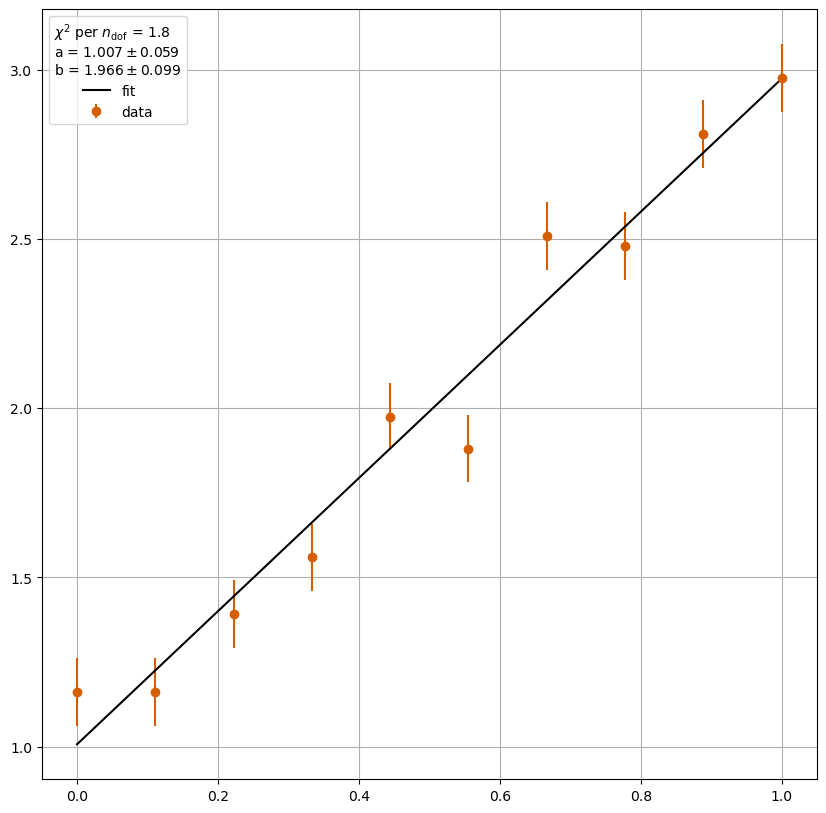

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares #Importing cost function to fit, the LeastSquares function

#Our straight line model 
def line(x, a, b):
    return  b*x + a

#Generate random toy data with random offsets in y
np.random.seed(1) #Ensures the 'toy data' is the same each time
X = np.linspace(0, 1, 10)
yerr = 0.1  # Could also be an array, with an error for each point
y = line(X, 1, 2) + yerr * np.random.randn(len(X))

#iminuit contains a LeastSquares class to conveniently generate a least-squares cost function
least_squares = LeastSquares(X, y, yerr, line)

m = Minuit(least_squares, a=0, b=0)  #Starting values for a and b

m.migrad() #Finds minimum of least_squares function
m.hesse()  #Accurately computes uncertainties

#Prints table of information
print(m)

#Prints value and error estimates in angled brackets
print(m.values)
print(m.errors)

#Prints individual values
print(m.values[0])
print(m.errors[0]) 

#Draw data and fitted line
plt.rcParams['figure.figsize'] = [10, 10]  #Changes size of graph
plt.errorbar(X, y, yerr, fmt="o", label="data", color='#D55E00')
plt.plot(X, line(X, *m.values), label="fit", color='black')
plt.grid()

#Display legend with some information about the fit
chipern=m.fval/(len(X)-m.nfit)

fit_info = [
    f"$\\chi^2$ per $n_\\mathrm{{dof}}$ = {chipern:.1f}",
]

#Print out the parameters, values and errors to see the format
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    

plt.legend(title="\n".join(fit_info))
plt.show()

Here we have shown how to obtain the fit, estimates for given parameters as well as errors associated with the estimators. In section **______** below, we will go through specific syntax of iminuit.

An important feature of iminuit is that it uses **introspection** to detect the parameter names within your function. For example, you can individually name certain parameters inside the function such as `a=1` (using keywords) rather than having to remember a specific order to put the parameters in. 

iminuit's minimisation algorithm MIGRAD uses a mix of **gradient descent** and the **Newton–Raphson method** to find the minimum of the cost function.

### Gradient Descent [^](#index) <a id='gd'></a>

Gradient Descent is a generic algorithm which aims to minimise a cost function (as seen previously), by choosing an optimal $\boldsymbol{\theta}$. It starts at some initial guess $\boldsymbol{\theta}_{init}$, and repeatedly updates this with the goal of converging to a value which minimises the cost function. A cost function often used is the **negative log-likelihood** $q$, however the least squares cost function can also be used. The gradient of this defines a direction in which the negative log-likelihood changes most rapidly, which is the optimal direction to search for a minimum in $q$. 

The amount we step in the direction of the minimum is called the **learning rate** and is often tuned to be an optimal value. This is in a class of parameters called a **hyperparameter**, which can be defined as *a parameter of a learning algorithm, and not of the model*. This is such that it is not affected by the learning algorithm itself and it must be set prior to training and remains constant during training. Tuning our hyperparameter is something we will return to and is key concept.

If this learning rate is set too high, you can miss the minimum entirely and `ping' back and forth between either end of a minimum without reaching it and if it is too small then it will take a large amount of time to minimise this. 

<td><img src=week4_photos/learning_rate.png align='center' height=400/></td>

*PLACEHOLDER: Image of learning rate and what making it too high or low does*

<div style="background-color:#FFCCCB">

### Mathematics of Gradient Descent

For any given cost function, as a result of a minimum needing to exist, the second derivative of the function must exist.

The initial guess is updated using 
$$
\boldsymbol{\theta}_{k} = \boldsymbol{\theta}_{init} - \alpha\nabla q\rvert_{\boldsymbol{\theta}_{init}} 
$$
We step along the negative gradient direction until we find a minimum, where $\alpha$ is the **learning rate**.


## Section Three: Bootstrapping

The method of bootstrapping instead, only relies on re-sampling from your existing dataset. Suppose you have a dataset $\{X_{1}, X_{2}, ..., X_{N}\}$ of random, *independent* observations. Then you produce a bootstrap sample by randomly selecting $K$ of the observations, replacing them each time (so they can be picked). From multiple such samples, you can calculate some quantity and use them to
estimate properties of the distribution of that quantity.

We can use python’s `random.choice` module for this, as in the snippet below which picks 6 random elements from a python list of 10 integers:

In [ ]:
import random
random_selection = random.choices([1,4,2,5,6,3,8,7,9,10], k=6)

Note that the ‘choices‘ function samples *with replacement* (so we can see the same element more than once in the returned list). To sample *without replacement* in python, we can
use `random.sample` instead.

Here we estimate the standard deviation of the sample mean in random number generated by a Gaussian distribution with $\mu=10$ and $\sigma=1$:

0.1389200428058241


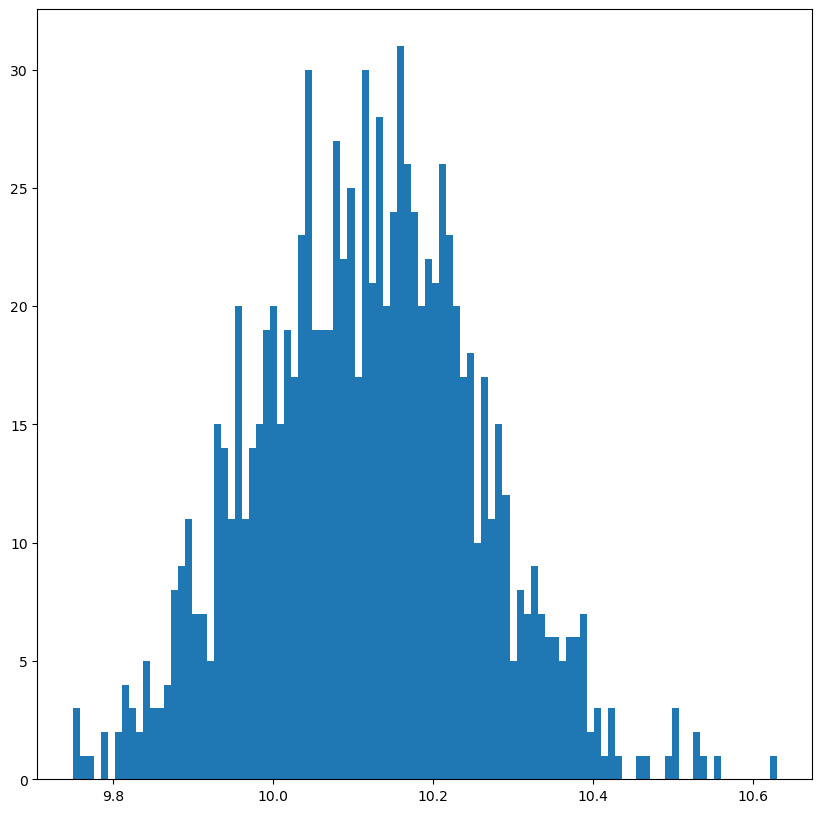

In [35]:
import numpy
observations = numpy.random.normal(10,1,100)
def sample_mean(data):
    return numpy.mean(data)

nsamples = 1000
means = []

for s in range(nsamples):
    bootstrap = random.choices(observations, k=50)
    means.append(sample_mean(bootstrap))

print(numpy.std(means))

plt.hist(means,bins=100)
plt.show()

The result of this is around $0.1$. This is much smaller than the standard deviation $\sigma$ of the original Gaussian. This is expected because we are not estimating the $\sigma$ parameter of the Gaussian, but rather we are estimating the *standard deviation of the sample mean*. You should be careful when dealing with small lists of observations, since theres a limit to the number of unique bootstrap samples that can be obtained which is given by $\frac{(2N−1)!}{N!×(N−1)!}$. In our example this number is $\frac{199!}{(100!)(99!)}$ so you don’t need to worry.

Comparing to the mean of the original observations, we can see that the mean of the distribution is indeed similar to the estimate from the observations: 

In [36]:
print(sample_mean(observations))
print(sample_mean(means))

10.118960524785688
10.117786776217658


We can also estimate the variance of the standard deviation estimator with the bootstrapping method. Again we plot a histogram of the std deviation across the bootstrap samples:

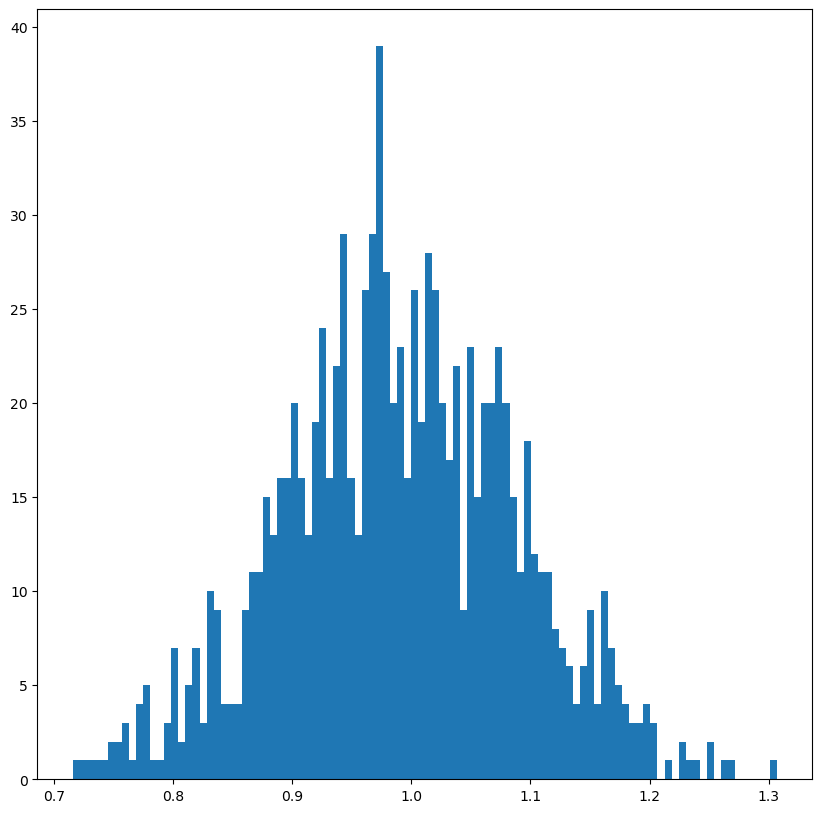

0.9903651874909059


In [37]:
stddevs = []
for s in range(nsamples) : 
    bootstrap = random.choices(observations, k=50)
    stddevs.append(sample_std_dev(bootstrap))

plt.hist(stddevs,bins=100)
plt.show()
print(sample_mean(stddevs))

A desireable property of an estimator is that for large data sets (as the number samples increases), the estimator should converge to the true value of the population parameter. Otherwise, we would end up with biased results even in the limit of infinite data. We call this property **consistent**.

Likelihood based estimators are consistent and we can check if method of moments estimators in this case are consistent.  To do this, we see how close the sample estimators for $\mu$ and $\sigma$ come to the true values, as we increase the number in our sample $N$:

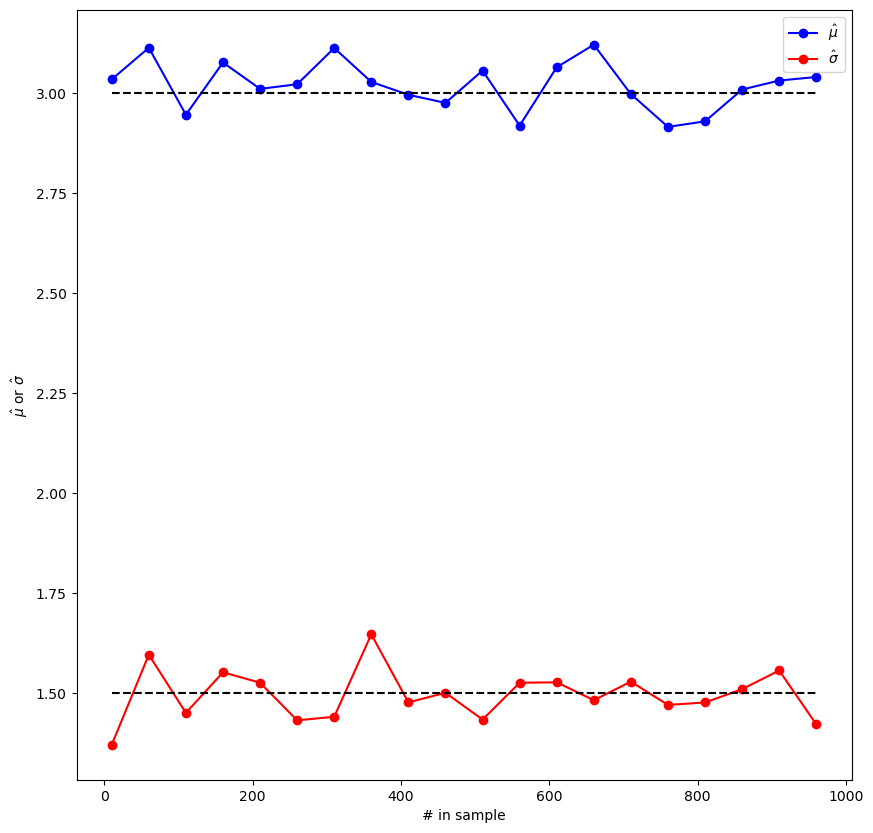

In [38]:
ns_sets = range(10,1000,50)
mu_hats = []
sigma_hats = []

for nsamples in ns_sets:
    toys = norm.rvs(mu_true, sigma_true, size=nsamples)
    mu_hats.append(numpy.mean(toys))
    sigma_hats.append(numpy.std(toys))

plt.plot(ns_sets,mu_hats, color='blue', marker="o", label="$\hat{\mu}$")
plt.plot(ns_sets,sigma_hats, color='red', marker="o", label="$\hat{\sigma}$")
plt.xlabel("# in sample")
plt.ylabel("$\hat{\mu}$ or $\hat{\sigma}$")

plt.plot([ns_sets[0],ns_sets[-1]], [mu_true,mu_true], color='black', linestyle="--")
plt.plot([ns_sets[0],ns_sets[-1]], [sigma_true,sigma_true], color='black', linestyle="--")

plt.legend()
plt.savefig("moments_norm_example.pdf")
plt.show()

Of course, until we reach infinity, we can't be sure that the estimator has converged to the true values. In fact, you can see that if you run the cell above again, the plots look different. This is because there is an intrisic variation on our moment estimators -- they are also random variables

## Section Four: Properties of Estimators

### Expectation of Estimators: Bias

One property of estimators that we are interested in is the **bias** of the estimator. The bias of an estimator is given by the expectation of the difference between the estimator and the true value of the parameter being estimated

\begin{equation*}
bias(\theta) = E[\hat{\theta}-\theta],
\end{equation*}

where $\hat{\theta}$ being the estimate for the paramater $\theta$. An estimator is unbiased if $bias(\theta) = 0$. For the case of a normal distribution, the estimator of the $\mu$ is unbiased. We can check this with toy data by generating samples from our normal distribution and estimating the $\mu$. We also saw that instead, the estimator for the $\sigma$ is not unbiased.

The bias depends on the sample size, so first lets see what this looks like for a dataset of 10 entries. Change `num_entries` to see how/if the bias changes as a function of the sample size. 

E[mu_hat]    = 3.00499
E[sigma_hat] = 1.38054


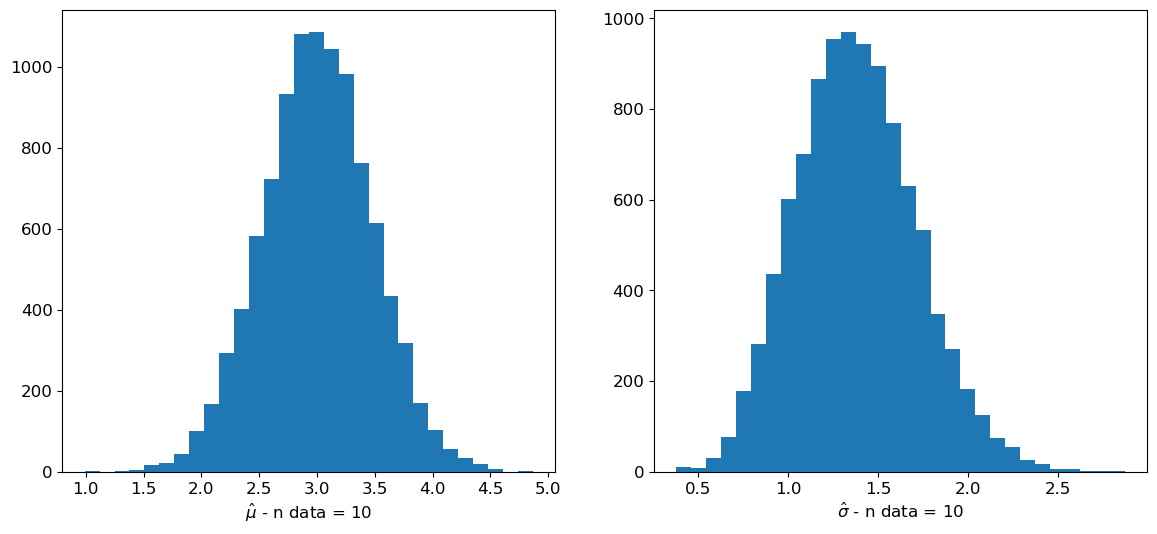

In [39]:
num_entries = 10 
number_of_mc_samples = 10000 # number of MC used to determine expectation. 
toys = []
for i in range(number_of_mc_samples): 
    toys.append(norm.rvs(mu_true,sigma_true,size=num_entries))

plt.rcParams.update({'font.size': 12})
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.hist([numpy.mean(toys[i]) for i in range(number_of_mc_samples)], bins=30)
ax2.hist([numpy.std(toys[i]) for i in range(number_of_mc_samples)], bins=30)
ax1.set_xlabel("$\hat{\mu}$ - n data = %d"%num_entries)
ax2.set_xlabel("$\hat{\sigma}$ - n data = %d"%num_entries)

mean_of_mu    = numpy.mean([numpy.mean(toys[i]) for i in range(number_of_mc_samples)])
mean_of_sigma = numpy.mean([numpy.std(toys[i]) for i in range(number_of_mc_samples)])

print("E[mu_hat]    = %g"%mean_of_mu)
print("E[sigma_hat] = %g"%mean_of_sigma)

plt.savefig("bias_of_estimator.pdf")
plt.show()

In [40]:
number_of_mc_samples = 10000 # number of MC used to determine expectation. 

def calculate_bias_mu(num_entries): 
    toys = []
    for i in range(number_of_mc_samples): 
        toys.append(norm.rvs(mu_true,sigma_true,size=num_entries)) 
    b_mu = numpy.mean([numpy.mean(toys[i]) for i in range(number_of_mc_samples)])   
    return b_mu
    
def calculate_bias_sigma(num_entries): 
    toys = []
    for i in range(number_of_mc_samples): 
        toys.append(norm.rvs(mu_true,sigma_true,size=num_entries)) 
    b_sig= numpy.mean([numpy.std(toys[i]) for i in range(number_of_mc_samples)])
    return b_sig
    
bias_mu    = [calculate_bias_mu(n) for n in ns_sets]
bias_sigma = [calculate_bias_sigma(n) for n in ns_sets]

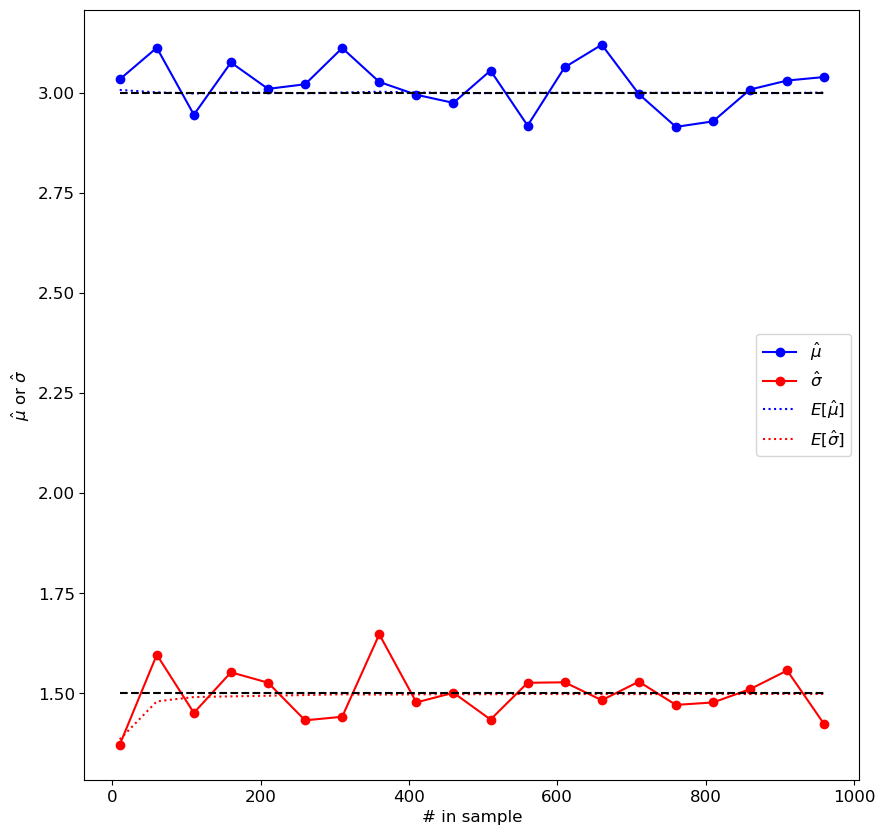

In [41]:
plt.plot(ns_sets,mu_hats,color='blue',marker="o",label="$\hat{\mu}$")
plt.plot(ns_sets,sigma_hats,color='red',marker="o",label="$\hat{\sigma}$")
plt.plot(ns_sets,bias_mu,color='blue',linestyle='dotted',label="$E[\hat{\mu}]$")
plt.plot(ns_sets,bias_sigma,color='red',linestyle='dotted',label="$E[\hat{\sigma}]$")

plt.xlabel("# in sample")
plt.ylabel("$\hat{\mu}$ or $\hat{\sigma}$")

plt.plot([ns_sets[0],ns_sets[-1]],[mu_true,mu_true],color='black',linestyle="--")
plt.plot([ns_sets[0],ns_sets[-1]],[sigma_true,sigma_true],color='black',linestyle="--")

plt.legend()
plt.savefig("moments_norm_example_with_bias.pdf")

### Consistent

As we discussed previously, an estimator converging to the true value of the parameter you are trying to estimate as you increase the number of samples is called being *consistent*. This property ensures our estimates get more accurate with more data. 

The method of moments fits this critera and above we showed this by seeing if the values looked like they were converging.

<div style="background-color:#FFCCCB">

### Mathematical proof that Method of Moments consistency

We can show that the method of moments estimator for the $\mu$ parameter of a Gaussian is
a consistent estimator by using the **law of large numbers**. Remember that the law of large
numbers says that if we have a sequence of random variables $X_{i}$ distributed according to
some distribution with a first algebraic moment $\mu$ and second central moments $\nu_{2}^{i}$, then if 

\begin{equation*}
\lim_{N\to\infty}\left(\frac{1}{N^{2}}\sum_{i=1}^{N}\nu_{2}^{i}\right)=0,
\end{equation*}

we have that the sample mean converges in probability to $\mu$, $\bar{X}=\frac{1}{N}\sum_{i=1}^{N}X_{i}\rightarrow\mu_{1}=\mu$.

The method of moments estimator for the $\mu$ parameter of a Gaussian is just the sample
mean. For a given sample size $N$, the variance of the sample mean is given by,

\begin{equation*}
V(\bar{X}_{N})=v\left(\frac{1}{N}\sum_{i=1}^{N}X_{i}\right)= \frac{1}{N^{2}}\sum_{i=1}^{N}V(X_{i})=\frac{1}{N}\sigma^{2}.
\end{equation*}

The sum required by the law of large numbers yields,
\begin{equation*}
\frac{1}{N^2}\sum_{i=1}^{N}=\frac{1}{N^{2}}\sum_{i=1}^{N}\frac{1}{N}\sigma^{2}=\frac{1}{N^2}\sigma^2
\end{equation*}

which clearly converges to 0 as $N \rightarrow \infty$. This means that by the law of large numbers, we must have that $\hat{µ}_{N} = \bar{X}_{N} \rightarrow N$  as $N \rightarrow \infty$, so it is a consistent estimator.

It is possible, in general to show that any of the method of moments estimators derived as a solution to the equations which match sample moments to moments of the distribution will yield consistent estimators

### Issues with Fitting

There are some common issues with fitting, which are:

* **Overfitting**: overfitting describes the situation where the curve being fit has too many paramaters and the subsequent curve goes through each point in your data. The fit is sufficiently complex that it can perfectly predict the training data, e.g. fitting a high order polynomial to data that is perhaps better modelled as a linear relationship with some noise. This results in poor prediction for the parameters or gives parameters which are unphysical.

* **Underfitting**: the opposite of overfitting, this occurs when the attempted fit is not sufficiently complex enough to capture the parameters you are trying to predict. An example would be trying to fit a quadratic dataset with a linear model, so you could be missing key physics as a result.

<img src=week4_photos/under_vs_over_fitting.png height = 600 align='center'>

*Example of under- and overfitting on quadratic data. The generated data is quadratic with Gaussian noise. The linear model clearly underfits and does not accurately approximate the data, whereas the high-order polynomial (order 300) overfits, resulting in predictions that will not generalise despite good performance on the existing data.*

* **Picking the "right" fit**: This is a core issue, although on the surface can not seem like one. If you see some data that peaks around a certain value and has a spread around it, it may be tempting to assume this is a Gaussian profile and call it a day. However, this may not be the case. It is possible that it is an entirely different fit which only graphically looks similar. Thinking about the physics behind the process rather than what model you think would fit through all the points nicely is the key to ensuring that your fit is justified. (PLACEHOLDER)

<img src=week4_photos/Gaussian,_Lorentzian_and_Voigt_profiles.png height = 600 align='center'>

*Example of three fits that look similar graphically, however are not exactly the same and describe different distributions.*  

<hr style="border:2px solid gray">

# Section Two: iminuit [^](#index) <a id='im'></a>
In the process of fitting the model, the error from your predictions to your training outputs should be minimised. When measuring physical quantities, the **uncertainty** of the measurement is paramount to analysis. 

## The Basics <a id='tb'></a>

You will learn basic usage of iminuit and how to approach standard fitting problems. `iminuit` is a Python frontend to the Minuit library in C++, an integrated software that combines a local minimizer, called Migrad, which uses the method of **gradient descent** and **Newton's method** and two error calculators, called Hesse and the Minos. 

The basic idea is you provide an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from an initial guess. In that regard, iminuit minimizer is like other local minimizers, like those in scipy.optimize. In addition, iminuit has the ability to compute **uncertainty estimates** for **model parameters**. iminuit was designed to solve statistics problems, where uncertainty estimates are an essential part of the result. The two ways of computing uncertainty estimates, Hesse and the Minos, have different advantages and disadvantages.

## The Minuit object <a id='tmo'></a>

### Initializing the Minuit object

To minimize a function, one has to create an instance of the `Minuit` class, pass the function, and a starting value for each parameter. **Note:** this does not start the minimization yet, this will come later.

In [15]:
#Create an instance of the Minuit class
m = Minuit(least_squares, a=0, b=0)

If we forget a parameter or mistype, Minuit will raise an error - see 2 examples of this below:

In [49]:
m=Minuit(least_squares)

RuntimeError: starting value(s) are required for a b

In [16]:
m=Minuit(least_squares,a=0,v=0)

RuntimeError: v is not one of the parameters [a b]

### Initial Parameter Values

If your function has several minima, the minimum found will depend on the starting point. Even if it has only one minimum, if you start in the proximity of the minimum, iminuit will converge to it faster. You can set the starting point using the parameter names as keywords, `name = value`.

In [17]:
Minuit(least_squares, a=5, b=5)  # pass starting values for a and b

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,,,
1,b,5.00,0.05,,,,,


Alternatively, the starting values can also be passed as positional arguments, like below:
```
Minuit(least_squares, 5, 5)
```

### Using iminuit with Numpy Arrays

You can also use iminuit with functions that accept numpy arrays. This has pros and cons:

**Pros**
* Simpler to change number of fitted parameters,
* Sometimes simpler function body (coding statements that are executed when function is run) that’s easier to read,
* Technically this is more efficient, but this is hardly going to be noticable.

**Cons**
* iminuit cannot figure out names for each parameter

To demonstrate, we will use a version of the straight line model which accepts the parameters as a numpy array.

In [18]:
def line_np(x, par):
    return np.polyval(par, x)  #For len(par) == 2, this is a straight line

Calling line_np with more or less arguments is simple. For $n$ arguments, a polynomial of order $n-1$ is used to predict the behavior of the data. The built-in cost functions support such a model. For it to be detected properly, you need to pass the starting values in the form of a single sequence of numbers. By starting values, we mean the point at which the minimiser starts from when searching for a local minimum.

In [20]:
least_squares_np = LeastSquares(X, y, yerr, line_np)

Minuit(least_squares_np, (5, 5))  #Pass starting values as a sequence

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,


We have used a tuple here for initialisation, but any sequence will work. We could instead have passed a list or a numpy array here. iminuit uses the length of the sequence to detect how many parameters the model has. By default, the parameters are named automatically $x_0$ to $x_N$. 

One can override this with the keyword argument `name`, passing a sequence of parameter names. Of course, this sequence must be of the same length as the sequence of starting points.

In [21]:
Minuit(least_squares_np, (5, 5), name=("a", "b"))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,,,
1,b,5.00,0.05,,,,,


Since least_squares_np works for parameter arrays of any length, one can easily change the number of fitted parameters.

In [ ]:
#Fit a third order polynomial
Minuit(least_squares_np, (5, 5, 5, 5))

It is often useful to try different orders of a polynomial model. If the order is too small, the polynomial will not follow the data. If it is too large, it will overfit the data and pick up random fluctuations, as opposed to the underlying trend. We can figure out the right order by experimenting or using an algorithm like **cross-validation** (which you will hear more about in the next couple of weeks).

### Inspecting current parameters
You can check the current parameter values and settings with the method `Minuit.params` at any time. It returns a special list of Param objects which pretty-prints (a specific way to present data) in Jupyter and in the terminal.

In [23]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.0,0.1,,,,,
1,b,0.0,0.1,,,,,


This produces a nice table with numbers rounded according to the rules of the *Particle Data Group*. The table will be updated once you run the actual minimization. To look at the initial conditions later, use `Minuit.init_params`. We will come back to the meaning of Hesse Error and Minos Error. `Minuit.params` returns a tuple-like container of Param objects, which are data objects with attributes that one can query. Use `repr()` to get a detailed representation of the data object.


In [24]:
for p in m.params:
    print(repr(p), "\n")

Param(number=0, name='a', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None) 

Param(number=1, name='b', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None) 



### Parameters with Limits
iminuit allows you to set parameter limits. Often a parameter is limited (mathematically or physically) to a certain range. For example, if your function contains $\sqrt{x}$, then $x$ must not be negative, $x \geq 0$. You can set upper-, lower-, or two-sided limits for each parameter individually with the limits property. You can see how this would be helpful for CERN, where masses shouldn't be negative.

* lower limit: `Minuit.limits = (<value>, None)` or `(<value>, float("infinity"))`
* upper limit: `Minuit.limits = (None, <value>)` or `(-float("infinity"), <value>)`
* two-sided limit: `Minuit.limits = (<min_value>, <max_value>)`
* remove limits: `Minuit.limits = None`  or `(-float("infinity"), float("infinity"))`

You can also set limits for several parameters at once with a sequence. To impose the limits $a\geq0$ and $0\leq b\leq10$ in our example, we use:

In [25]:
m.limits = [(0, None), (0, 10)]
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.0,0.1,,,0,,
1,b,0.0,0.1,,,0,10,


### Fixing and Releasing Parameters
In some cases, you may have a parameter that needs to be temporarily set to a fixed value. This can be useful when you have a guess for its value and want to observe how the other parameters adapt when a specific parameter is held constant. Alternatively, if you have a complex function with numerous parameters that have varying impacts on the function, you can assist the minimizer in finding the minimum faster by initially fixing the less influential parameters to their initial guesses and only fitting the significant parameters. 

Once the minimum is obtained, you can release the fixed parameters and optimize all the parameters together. Minuit retains the previous minimization state and resumes from there. The **time for minimization** approximately scales with the **square of the number of parameters**. By performing **iterated minimization** over parameter subspaces, this **time can be reduced**. To fix an individual parameter, you can utilise the keyword `Minuit.fixed[name] = True`. In our example, we fix parameter $a$ as follows:

In [26]:
m.fixed["a"] = True
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.0,0.1,,,0,,yes
1,b,0.0,0.1,,,0,10,


In [ ]:
# migrad will not vary α, only β
m.migrad()

In [ ]:
# now we release α and fix β and minimize again, can also use parameter index
m.fixed[0] = False
m.fixed[1] = True
m.migrad()

### Varying Starting Points for Minimization ###

It is sometimes useful to manually change the values of some fixed parameters and fit the others, or to restart the fit from another starting point. For example, if the cost function has several minima, changing the starting value can be used to find the other minimum.

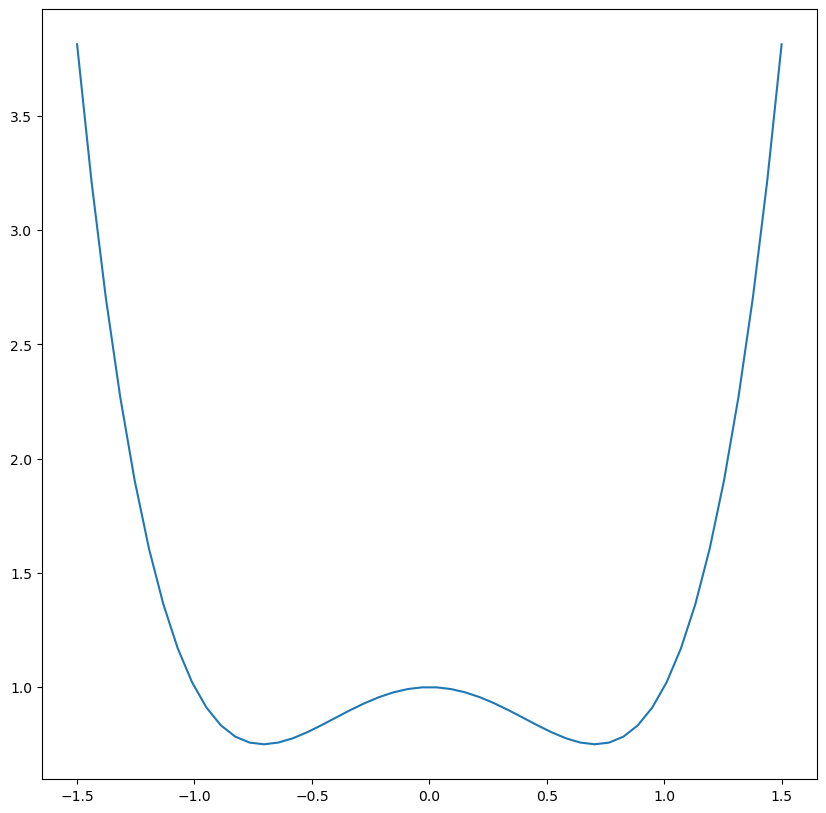

In [27]:
def cost_function_with_two_minima(x):
    return x ** 4 - x ** 2 + 1

#We come back to the meaning of errordef in the next section
cost_function_with_two_minima.errordef = Minuit.LEAST_SQUARES

x = np.linspace(-1.5, 1.5)
plt.plot(x, cost_function_with_two_minima(x));

In [28]:
#Starting at -0.1 gives the left minimum
m = Minuit(cost_function_with_two_minima, x=-0.1)
m.migrad()
print("starting value -0.1, minimum at", m.values["x"])

# changing the starting value to 0.1 gives the right minimum
m.values["x"] = 0.1  # m.values[0] = 0.1 also works
m.migrad()
print("starting value +0.1, minimum at", m.values["x"])

starting value -0.1, minimum at -0.7085906080341975
starting value +0.1, minimum at 0.708796091342642


### Investigating the fit status
Calling `Minuit.migrad()` runs the minimization with the Migrad algorithm. Migrad essentially tries a **Newton-step** and if that does not produce a smaller function value, it tries a line search along the direction of the gradient. The clever part in the function Migrad is how various cases are handled. Let’s look again at the output of `Minuit.migrad()`.

In [40]:
m = Minuit(least_squares, a=5, b=5)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (chi2/ndof = 1.8)    │              Nfcn = 30               │
│ EDM = 1.58e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ b    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00345 -0.00491 │
│ b │ -0.00491  0.00982 │
└───┴───────────────────┘

The first block in this output is showing information about the function minimum. This is good for a quick check:

All blocks should be green:
* Purple means something has gone awry,
* Yellow may be bad or not, proceed with caution.

Let’s see how it looks when the function is bad:

In [30]:
m_bad = Minuit(lambda x: 0, x=1)  # a constant function has no minimum
m_bad.errordef = 1  # avoid the errordef warning
m_bad.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 80               │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │     1     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Coming back to our previous good example, the info about the function minimum can be directly accessed with Minuit.fmin:



In [31]:
m.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (chi2/ndof = 1.8)    │              Nfcn = 30               │
│ EDM = 1.58e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [32]:
# print(repr(...)) to see a detailed representation of the data object
print(repr(m.fmin))

<FMin algorithm='Migrad' edm=1.5774541063068123e-21 edm_goal=0.0002 errordef=1.0 fval=14.064905067721467 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=30 ngrad=0 reduced_chi2=1.7581131334651834 time=0.00045364900142885745>


The most important one here is `is_valid`. If this is false, the fit does not converge and the result is useless. Since this is so often queried, a shortcut is provided with `Minuit.valid`.

If the fit fails, there is usually a numerical or logical issue.

Either:

- The fit function is **not analytical everywhere in the parameter space**

or

- The fit function **does not have a local minimum**. The minimum may be at infinity, the extremum may be a saddle point or a maximum.

Indicators for this are `is_above_max_edm=True`, `hesse_failed=True`, `has_posdef_covar=False`, or `has_made_posdef_covar=True`. A non-analytical function is one with a discrete step, for example.

Possible problems are:

* Migrad reached the call limit before the convergence so that `has_reached_call_limit=True`. The used number of function calls is `nfcn`, and the call limit can be changed with the keyword argument `ncall` in the method `Minuit.migrad`. 

(Note: `nfcn` can be larger than `ncall`, because Migrad internally only checks this condition after a full iteration, in which several function calls can happen).

* Migrad detects convergence by a small **edm** value, the Estimated Distance to Minimum. This is the difference between the current minimum value of the minimized function and the prediction based on the current local quadratic approximation of the function, something that Migrad computes as part of its algorithm. If the fit does not converge, `is_above_max_edm=True`.

If you are interested in parameter uncertainties, make sure that:

* `has_covariance`, `has_accurate_covar`, and `has_posdef_covar` are `True`,
* `has_made_posdef_covar` and `hesse_failed` are `False`.

The second object of interest after the fit is the parameter list, which can be accessed with `Minuit.params`.

In [34]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.01,0.06,,,,,
1,b,1.97,0.10,,,,,


`m.params` is a tuple-like container of Parameter data objects, which contain information about the fitted parameters. The important fields are: 
- number: parameter index,
- name: parameter name, 
- value: value of the parameter at the minimum,
- error: uncertainty estimate for the parameter value.

The accuracy of the uncertainty estimate depends on two factors: the correct mathematical modeling of the fitting problem and the appropriate usage of the `errordef` value in Minuit. But what do we mean by "correct mathematical modeling"? To understand this, let's examine the function `simple_least_squares(a, b)`. 

Notice that each squared residual is divided by the expected variance of the residual. This division is crucial for obtaining accurate uncertainty estimates for the parameters. This is because the higher the uncertainty the less important the residual is, as we are less certain on the estimate produced.

In some cases, the expected variance of the residual may not be well-known. When the function to minimize is a least-squares function, there is a simple test to assess the adequacy of the residual variances. One can evaluate the function value at the minimum, denoted by `fmin.fval`, and divide it by the difference between the number of residuals and the number of fitted parameters. This difference can be conveniently obtained using the `nfit` attribute. This metric is the reduced $\chi^2$, which you should be familiar with this from prior weeks.

In [37]:
m.fval / (len(y) - m.nfit)  # reduced 𝛘 squared

1.7581131334651834

The ideal value is around 1. The more data points collected, the closer. If the value is much larger than 1, then the data variance is underestimated or the model does not describe the data well. If the value is much smaller than 1, then the data variance is overestimated (perhaps because of positive correlations between the fluctuations of the data values).

## Summary

In this section, you have been introduced to XYZ . This has included:

* XYZ
* XYZ
The next section will ABC.

<hr style="border:2px solid gray">

# Section Three: Parameter Uncertanties and Covariances [^](#section-) <a id='im'></a>

You saw how to get the uncertainty of each individual parameter and how to access the full covariance matrix of all parameters together, which includes the correlations. **??Not sure when, perhaps implicity above. Also are correlations/covariance matrices covered in the stats part of the course??**

Correlations are essential additional information if you want to work with parameter uncertainties seriously.

Minuit offers two ways to compute the parameter uncertainties, **Hesse** and **Minos**.

### Hesse for Covariance and Correlation Matrices
The Hesse algorithm numerically computes the matrix of second derivatives at the function minimum (called the Hesse matrix) and inverts it. In the limit of infinite data samples to fit, the result of this computation converges to the true covariance matrix of the parameters. It is often a good approximation even for finite statistic. The errors obtained from this method are sometimes called parabolic errors, because the Hesse matrix method is exact if the function is a hyperparabola (third and higher-order derivatives are all zero).

**Pros**
* Relatively fast computation,
* Provides covariance matrix for error propagation.

**Cons**
* May not have good coverage probability when sample size is small

The Migrad algorithm computes an approximation of the Hesse matrix during minimization. When the default strategy is used, Minuit does a check whether this approximation is sufficiently accurate and if not, it computes the Hesse matrix automatically. 

In [41]:
#Let's mess with the current errors, so that hesse has something to do
m.errors = (0.16, 0.2)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.01,0.16,,,,,
1,b,1.97,0.20,,,,,


In [42]:
m.hesse().params #Note the change in "Hesse Error"

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.01,0.06,,,,,
1,b,1.97,0.10,,,,,


To see the covariance matrix of the parameters, you do:

In [43]:
m.covariance

,a,b
a,0.00345,-0.00491 (-0.843)
b,-0.00491 (-0.843),0.00982


In [44]:
print(repr(m.covariance))

[[ 0.00345455 -0.00490909]
 [-0.00490909  0.00981818]]


To get the correlation matrix

In [45]:
m.covariance.correlation()

,a,b
a,1,-0.843
b,-0.843,1


Non-zero correlation is not necessarily a bad thing, but if you have freedom in redefining the parameters of the fit function, it is good to choose parameters which are not strongly correlated. Minuit cannot accurately minimise the function if two parameters are almost perfectly (anti-)correlated. It also means that one of two parameters is superfluous, it doesn’t add new information. You should rethink the fit function in this case and try to remove one of the parameters from the fit.

Both matrices are subclasses of `numpy.ndarray`, so you can use them everywhere you would use a numpy array. In addition, these matrices support value access via parameter names:

In [46]:
m.covariance["a", "b"]

-0.004909092060230799

### Minos for non-parabolic minima
Minos implements the **profile likelihood method**, where the neighborhood around the function minimum is scanned until the contour is found where the function increase by the value of `errordef`. The contour defines a confidence region that covers the true parameter point with a certain probability. The probability is exactly known in the limit of infinitely large data samples, but approximate for the finite case. Please consult a textbook about statistics about the mathematical details or look at the tutorial “Error computation with HESSE and MINOS”.

**Pros**

* Produces pretty confidence regions in 2D (or higher) for scientific plots

**Cons**
* Computationally expensive
* Asymmetric errors are difficult to error-propagate

Minos is not automatically called during minimization, it needs to be called explicitly afterwards:

In [47]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                               External                                  │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (chi2/ndof = 1.8)    │              Nfcn = 77               │
│ EDM = 2.75e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.06    │   -0.06    │    0.06    │         │         │       │
│ 1 │ b    │   1.97    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │           a           │           b           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.06   │   0.06    │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00345 -0.00491 │
│ b │ -0.00491  0.00982 │
└───┴───────────────────┘

By now, you have likely become accustomed to seeing green colors, which indicate a successful run through. However, it is crucial to exercise caution if these colors turn red instead, as it signifies a failure of Minos. The fields in the new Minos table carry the following meanings:

* Valid: Indicates whether Minos considers the scan result valid,
* At Limit: Becomes true if Minos encounters a parameter limit before completing the contour, which is undesirable,
* Max FCN: Becomes true if Minos reaches the maximum number of allowed calls before completing the contour, also an undesirable outcome,
* New Min: Becomes true if Minos discovers a deeper local minimum in the vicinity of the current one. While not necessarily problematic, it should ideally be avoided.

The errors computed by Minos are now also shown in the parameter list.

In [48]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.01,0.06,-0.06,0.06,,,
1,b,1.97,0.10,-0.10,0.10,,,


<div style="background-color: #FFF8C6">

#### Coverage Probability of Intervals Constructed with Hesse and Minos Algorithms
In applications, it is important to construct confidence regions with a well-known coverage probability. As previously mentioned, the coverage probability of the intervals constructed from the uncertainties reported by Hesse and Minos are not necessarily the standard 68%.

Whether Hesse or Minos produce an interval with a coverage probability closer to the desired 68% in finite samples depends on the case. There are theoretical results which suggest that Hesse may be slightly better, however this is not always the case. 

Some sources claim that Minos gives better coverage when the cost function is not parabolic around the minimum; that is not generally true, in fact Hesse intervals may have better coverage. As a rule-of-thumb, use Hesse as the default and try both algorithms if accurate coverage probability matters.

### Access to Fit Results

You get the main fit results with properties and methods from the Minuit object. We used several of them already. Here is a summary:

In [52]:
print(m.values)  #Array-like view of the parameter values

#Access values by name or index
print("by name ", m.values["a"])
print("by index", m.values[0])

#Iterate over values
for key, value in zip(m.parameters, m.values):
    print(f"{key} = {value}")
    
#Slicing works
print(m.values[:1])

print(m.errors)  # array-like view of uncertainties

<ValueView a=1.007267694540621 b=1.9660364327564714>
by name  1.007267694540621
by index 1.007267694540621
a = 1.007267694540621
b = 1.9660364327564714
[1.007267694540621]
<ErrorView a=0.058775386128484715 b=0.099086750179578>


`Minuit.errors` supports the same access as `Minuit.values`:

In [53]:
print(m.params) #Parameter info (using str(m.params))

print(repr(m.params)) #{arameter info (using repr(m.params))

#Asymmetric uncertainties (using str(m.merrors))
print(m.merrors)

print(m.covariance)  # covariance matrix computed by Hesse (using str(m.covariance))
print(repr(m.covariance))  # covariance matrix computed by Hesse (using repr(m.covariance))

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.06    │   -0.06    │    0.06    │         │         │       │
│ 1 │ b    │   1.97    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
(Param(number=0, name='a', value=1.007267694540621, error=0.058775386128484715, merror=(-0.058775381364227115, 0.058775381364824526), is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='b', value=1.9660364327564714, error=0.099086750179578, merror=(-0.09908673886090376, 0.09908673886184209), is_const=False, is_fixed=False, lower_limit=None, upper_limit=None))
┌──────────┬───────────────────────┬─────────────────

As already mentioned, you can play around with iminuit by assigning new values to `m.values` and `m.errors` and then run `m.migrad()` again. The values will be used as a starting point.

<div style="background-color: #FFF8C6">

### Plotting

iminuit comes with a built in methods to draw the confidence regions around the minimum, like so:

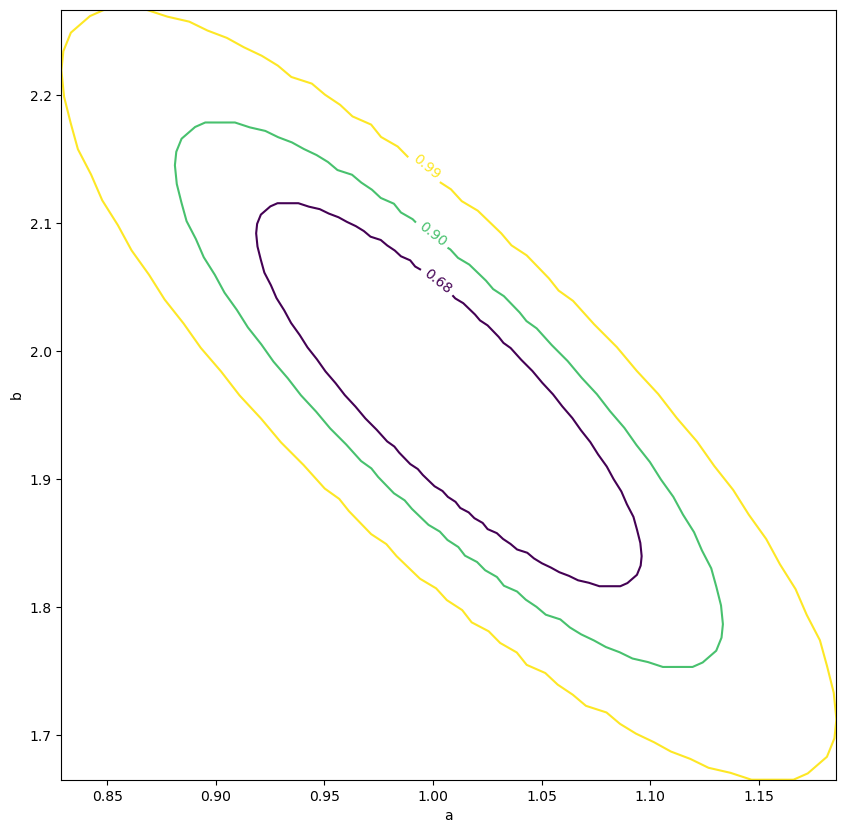

In [55]:
# find the minimum again after messing around with the parameters
m.migrad()

#Plots three contours with 68%, 90%, 99% confidence level
m.draw_mncontour("a", "b", cl=(0.68, 0.9, 0.99))

<div style="background-color: #FFF8C6">
Asymptotically (in large samples), the confidence level is equal to the probability that the region contains the true value. In finite samples, this is usually only approximately equivalent.


In [57]:
# get individual contours to plot them yourself
ctr_xy = m.mncontour("a", "b", cl=0.68, size=10)
print(ctr_xy)

[[0.91854084 2.09212197]
 [0.93860627 2.01263553]
 [0.97400646 1.9386927 ]
 [1.019001   1.86959111]
 [1.08205798 1.81645587]
 [1.09599455 1.8399509 ]
 [1.07592912 1.91943733]
 [1.04052893 1.99338016]
 [0.99553439 2.06248175]
 [0.93247741 2.115617  ]
 [0.91854084 2.09212197]]


If you need to inspect the cost function around the minimum because MINUIT warns you about some issues, you can quickly scan it with a call to `Minuit.draw_profile`.

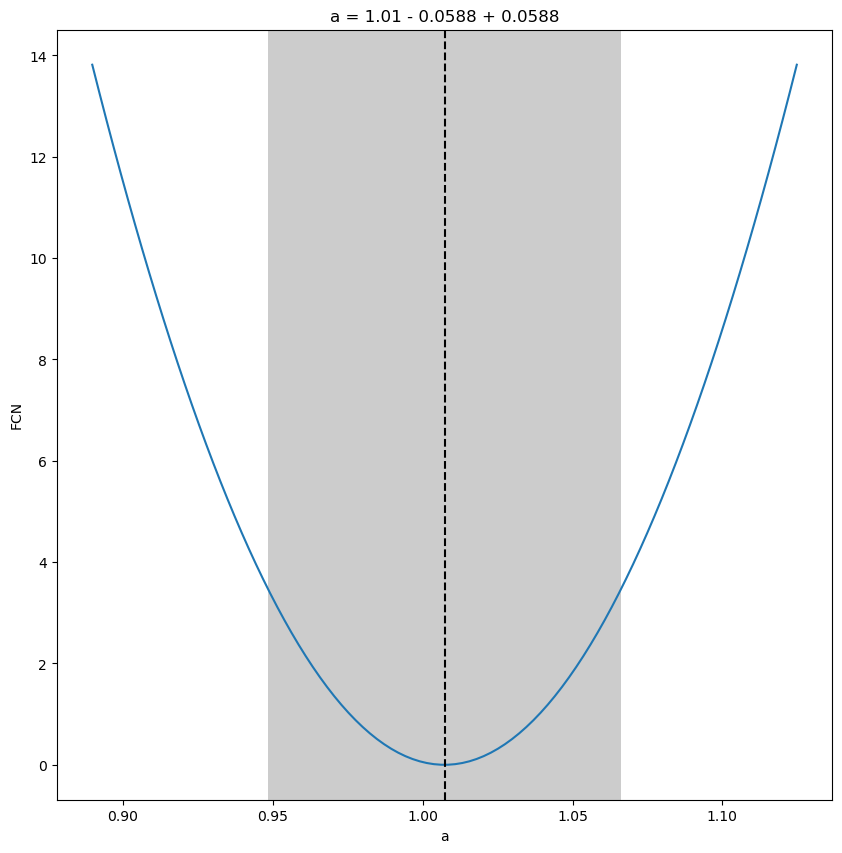

In [58]:
m.draw_profile("a");

Or use this to plot the result of the scan yourself:

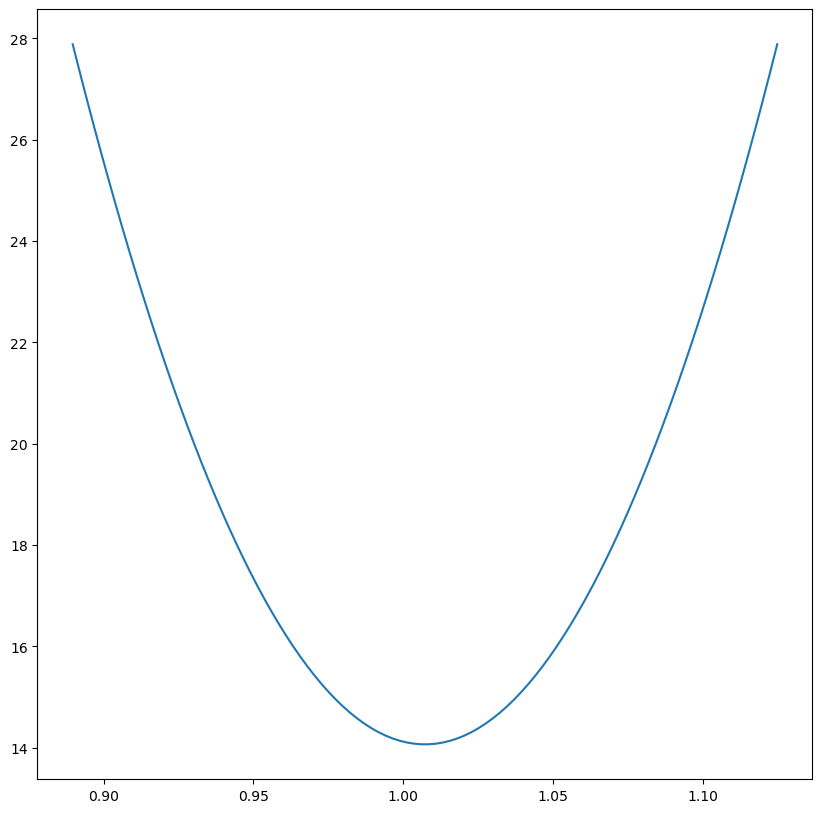

In [60]:
a, fa = m.profile("a")
plt.plot(a, fa)

Alternatively, you can use mnprofile to do a full profile likelihood scan. This mimics what MINOS does to compute confidence intervals. If you have trouble with MINOS, running this may help to inspect the issue. This is computationally expensive, since the scan runs MIGRAD for each point on the profile.

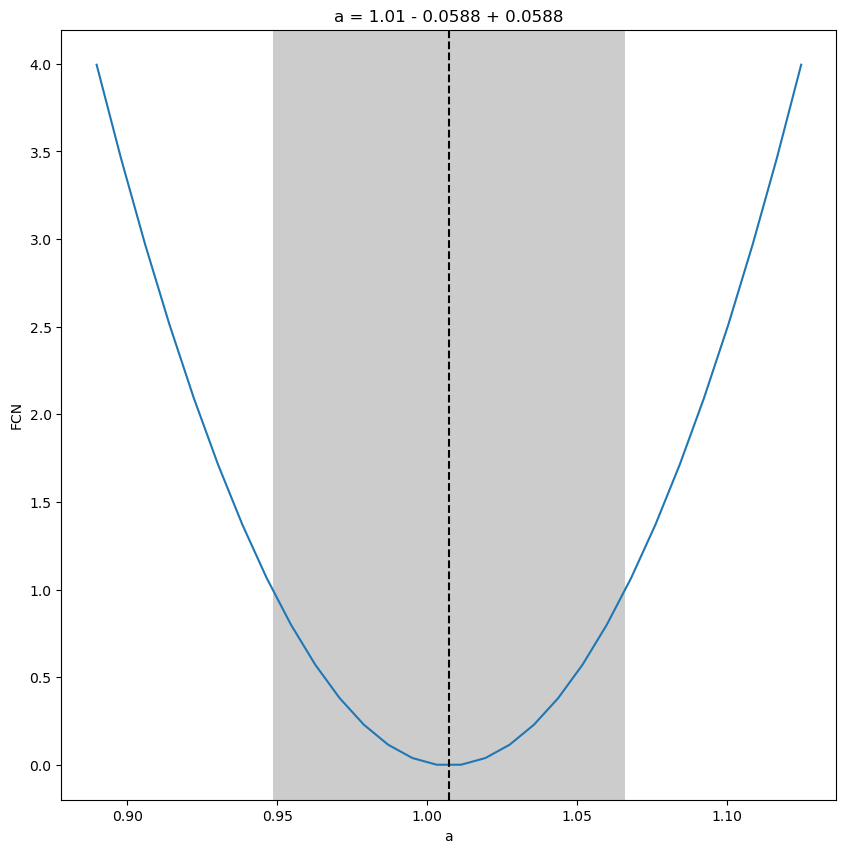

In [61]:
m.draw_mnprofile("a");

Finally, you can also look at the 2D contours of the cost function around the minimum. Note that these are just contours of the fit function, not confidence regions. The latter you can only get from mncontour.

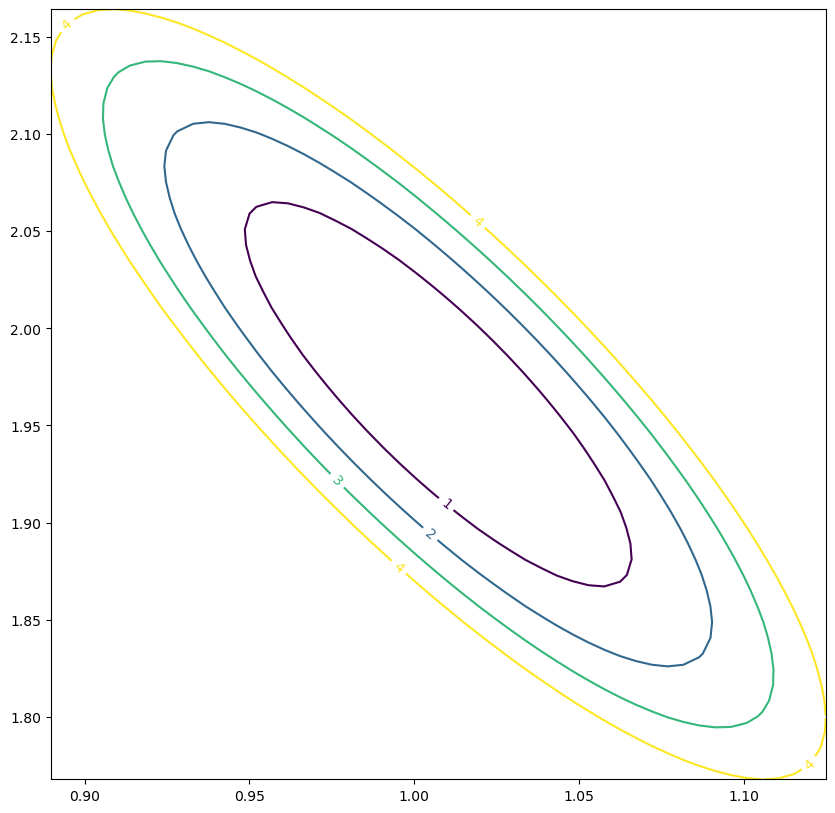

In [62]:
x, y, z = m.contour("a", "b", subtract_min=True)
#print(len(x))
cs = plt.contour(x, y, z, (1, 2, 3, 4))  # these are not sigmas, just the contour values
plt.clabel(cs);

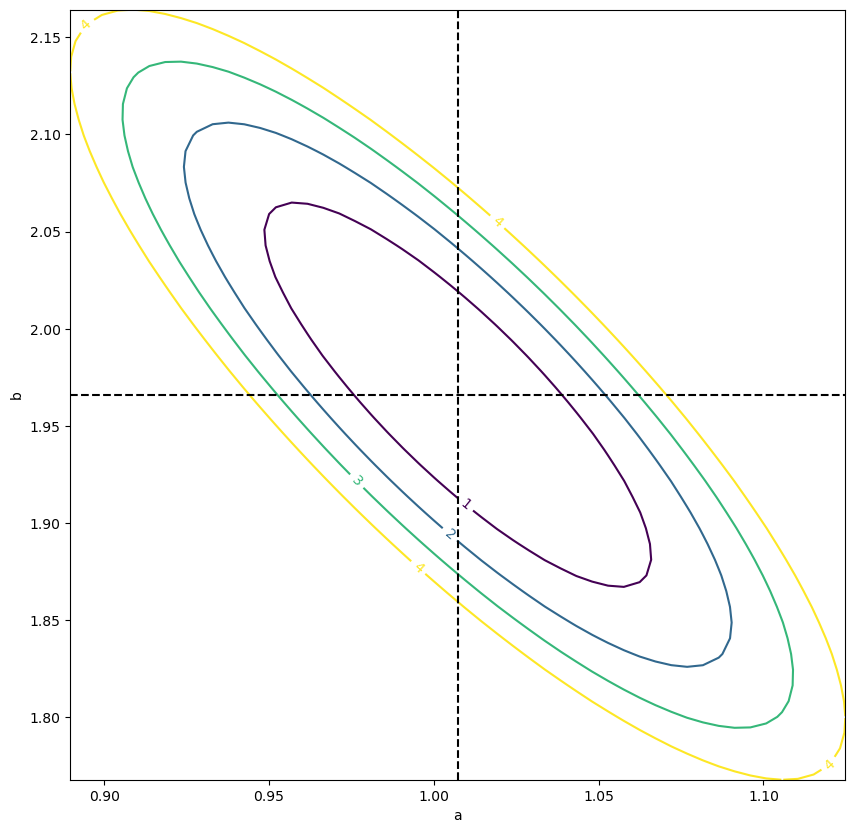

In [63]:
# or use this function for a quick look
m.draw_contour("a", "b");

### Cost functions
The iminuit package comes with a couple of common cost functions that you can import from `iminuit.cost` for convenience. Of course, you can write your own cost functions to use with iminuit, but most of the cost function is always the same. What really varies is the statistical model which predicts the probability density as a function of the parameter values. This you have to provide and the iminuit package will not include machinery to build statistical models.

Using the builtin cost functions is not only convenient, they also have some extra features.

* Support of fitted weighted histograms,
* Technical tricks improve numerical stability,
* Optional numba acceleration (if numba is installed),
* Cost functions can be added to fit data sets with shared parameters,
* Temporarily mask data.

We demonstrate each cost function on an standard example from high-energy physics, the fit of a peak over some smooth background (here taken to be constant).

In [64]:
from iminuit import cost, Minuit
from scipy.stats import norm, uniform
import numpy as np
from matplotlib import pyplot as plt

We generate our data. We sample from a Gaussian peak around 0 with width 0.1 and from uniform background from -1 to 1. We then bin the original data. One can fit the original or the binned data. The latter is often much faster and if the binning is fine enough, there is no loss in precision as we will see in the next chapter.

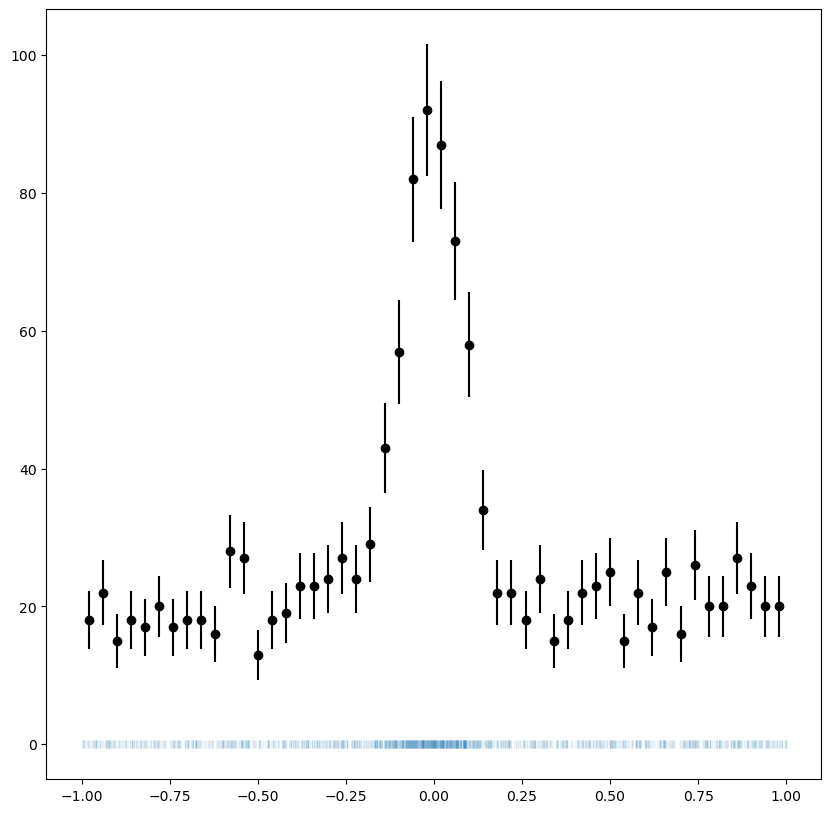

In [65]:
xrange = -1, 1

rng = np.random.default_rng(1)

xdata = rng.normal(0, 0.1, size=400)
xdata = np.append(xdata, rng.uniform(*xrange, size=1000))

n, xe = np.histogram(xdata, bins=50, range=xrange)  
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.plot(xdata, np.zeros_like(xdata), "|", alpha=0.1);

## Summary

In this section, you have been introduced to XYZ . This has included:

* XYZ
* XYZ
The next section will ABC.

<hr style="border:2px solid gray">

# Section Four: Maximum-likelihood Fits [^](#section-) <a id='im'></a>

Maximum-likelihood fits are the state-of-the-art when it comes to fitting models to data. The can be applied to unbinned and binned data (histograms). A maximum likelihood says we the parameters of the fit should be chosen such that the data has the highest probability of occuring, so the likelihood function should be maximised.

* Unbinned fits are the easiest to use, because they can be apply directly to the raw sample. They become slow when the sample size is large.
* Binned fits require you to appropriately bin the data. The binning has to be fine enough to retain all essential information. Binned fits are much faster when the sample size is large.

<div style="background-color: #FFF8C6">

### Unbinned fit
Unbinned fits are ideal when the data samples are not too large or very high dimensional. There is no need to worry about the appropriate binning of the data. Unbinned fits are inefficient when the samples are very large and can become numerically unstable, too. Binned fits are a better choice then.

The cost function for an unbinned maximum-likelihood fit is really simple, it is the sum of the logarithm of the pdf evaluated at each sample point (times -1 to turn maximimization into minimization). You can easily write this yourself, but a naive implementation will suffer from instabilities when the pdf becomes locally zero. Our implementation mitigates the instabilities to some extend.

To perform the unbinned fit you need to provide the pdf of the model, which must be vectorized (a numpy ufunc). The pdf must be normalized, which means that the integral over the sample value range must be a constant for any combination of model parameters.

The model pdf in this case is the weighted sum of the normal and the uniform pdfs. The parameters are  (the weight),  and  of the normal distribution. The uniform distribution is parameter-free. The cost function detects the parameter names.

It is important to put appropriate limits on the parameters, so that the problem does not become mathematically undefined: $0 \lt z \lt 1$ , $-1 \lt \mu \lt 1$  , $\sigma \gt 0$ .

In [66]:
def model_pdf(x, z, mu, sigma):
    return (z * norm.pdf(x, mu, sigma) +
            (1 - z) * uniform.pdf(x, xrange[0], xrange[1] - xrange[0])) #note how useful the ,pdf are

c = cost.UnbinnedNLL(xdata, model_pdf)

m = Minuit(c, z=0.4, mu=0, sigma=0.2)
m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)
m.limits["sigma"] = (0, None)

m.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1504                       │              Nfcn = 83               │
│ EDM = 3.42e-05 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.275   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000298 -3.66e-06  3.73e-05 │
│    mu │ -3.66e-06  3.79e-05 -2.32e-06 │
│ sigma │  3.73e-05 -2.32e-06  3.22e-05 │
└───────┴───────────────────────────────┘

<div style="background-color: #FFF8C6">

We can also visualize the results:

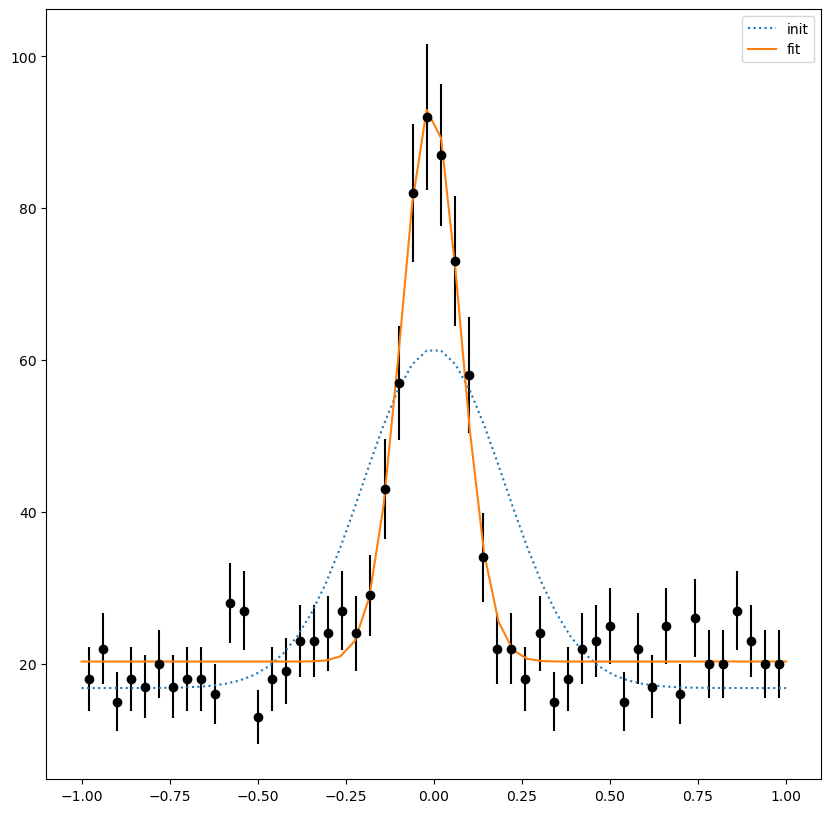

In [67]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_pdf(xm, *[p.value for p in m.init_params]) * len(xdata) * dx[0],
         ls=":", label="init")
plt.plot(xm, model_pdf(xm, *m.values) * len(xdata) * dx[0], label="fit")
plt.legend();

<div style="background-color: #FFF8C6">

### Extended unbinned fit

This is often used in the world of particle physics where we are trying to 

An important variant of the unbinned ML fit is described by Roger Barlow, *Nucl.Instrum.Meth.A 297 (1990) 496-506*. Use this if both the shape and the integral of the density are of interest. In practice, this is often the case, for example, if you want to estimate a cross-section or yield.

The model in this case has to return the integral of the density and the density itself (which must be vectorized). The parameters in this case are $n_{sig}$  (integral of the signal density), $n_{bkg}$ (integral of the uniform density), $\mu$  and $\sigma$ of the normal distribution. Again, the parameters need limits so that the problem is mathematically defined.

* $n_{sig} \gt 0$
* $n_{bkg} \gt 0$
* $-1 \lt \mu \lt 1$
* $\sigma \gt 0$

Compared to the previous case, we have one more parameter to fit. This is common to extended fits.

In [49]:
def model_density(x, nsig, nbkg, mu, sigma):
    return nsig + nbkg, (nsig * norm.pdf(x, mu, sigma) +
        nbkg * uniform.pdf(x, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedUnbinnedNLL(xdata, model_density)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)
m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

NameError: name 'cost' is not defined

<div style="background-color: #FFF8C6">

The fitted values and the uncertainty estimates for $\mu$ and $\sigma$  are identical to the ordinary ML fit.

In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_density(xm, *[p.value for p in m.init_params])[1] * dx[0],
         ls=":", label="init")
plt.plot(xm, model_density(xm, *m.values)[1] * dx[0], label="fit")
plt.legend()

<div style="background-color: #FFF8C6">

### Binned Fit
Binned fits are computationally more efficient and numerically more stable when samples are large. The caveat is that one has to choose an appropriate binning. The binning should be fine enough so that the essential information in the original is retained.

The sample investigate here is large enough and 50 bins are fine enough to retain all information. The maximum-likelihood method applied to binned data gives correct results even if bins no entries, so chosing a binning that is very fine is not an issue. It just increases the computational cost.

The cost functions for binned fits implemented here assume that the bin contents are independently Poisson distributed around an unknown expected value per bin. This is exactly correct for ordinary histograms.

For a binned maximum-likelihood fit, one sums the logarithm of Poisson probabilities for the observed counts as a function of the predicted counts in this case (times -1 to turn maximization into minimization). Instead of a pdf, you need to provide a cdf in this case (which must be vectorized). Note that you can approximate the cdf as “bin-width times pdf evaluated at center” if it is difficult to calculate, but this is an approxmiation. Using the cdf is exact.



In [ ]:
def model_cdf(xe, z, mu, sigma):
    return (z * norm.cdf(xe, mu, sigma) +
            (1-z) * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.BinnedNLL(n, xe, model_cdf)

m = Minuit(c, z=0.4, mu=0, sigma=0.2)

m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)
m.limits["sigma"] = (0, None)

m.migrad()

<div style="background-color: #FFF8C6">

The fitted values and the uncertainty estimates for μ and σ are not identical to the unbinned fit, but very close. For practical purposes, the results are equivalent. This shows that the binning is fine enough to retain the essential information in the original data.

In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_cdf(xe, *[p.value for p in m.init_params])) * len(xdata), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_cdf(xe, *m.values)) * len(xdata), xe, label="fit")
plt.legend();

<div style="background-color: #FFF8C6">

### Extended binned maximum-likelihood fit
The binned extended maximum-likelihood fit is strictly the binned equivalent of the corresponding unbinned fit. One sums the logarithm of Poisson probabilities for the observed counts as a function of the predicted counts in this case (times -1 to turn maximization into minimization).

Instead of a density, you need to provide a cdf of the density in this case (which must be vectorized). There is no need to separately return the total integral like the unbinned case. The parameters are the same as in the unbinned extended fit.

In [ ]:
def model_density_cdf(xe, nsig, nbkg, mu, sigma):
    return (nsig * norm.cdf(xe, mu, sigma) +
            nbkg * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedBinnedNLL(n, xe, model_density_cdf)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)

m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

<div style="background-color: #FFF8C6">

### Weighted histograms
The cost functions for binned data also support weighted histograms. Just pass an array with the shape (n, 2) instead of (n,) as the first argument, where the first number of each pair is the sum of weights and the second is the sum of weights squared (an estimate of the variance of that bin value).

### Least-Squares

A cost function for a general weighted least-squares fit, or a $\chi^{2}$ fit, is also included. In statistics this is called non-linear regression.

In this case you need to provide a model that predicts the $y$-values as a function of the $x$-values and the parameters. The fit needs estimates of the $y$-errors. If those are wrong, the fit may be biased. If your data has errors on the $x$-values as well, checkout the tutorial about automatic differentiation, which includes an application of that to such fits.

In [27]:
def model(x, a, b):
    return a + b * x ** 2

rng = np.random.default_rng(4)

x = np.linspace(0, 1, 20)
yt = model(x, 1, 2)
ye = 0.4 * x**5 + 0.1
y = rng.normal(yt, ye)

plt.plot(x, yt, ls="--", label="truth")
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.legend();

NameError: name 'np' is not defined

In [ ]:
c = cost.LeastSquares(x, y, ye, model)

m = Minuit(c, a=0, b=0)
m.migrad()

In [ ]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

## Summary

In this section, you have been introduced to XYZ . This has included:

* XYZ
* XYZ
The next section will ABC.

<hr style="border:2px solid gray">

# Section X: Exercises [^](#section-) <a id='im'></a>

<div style="background-color:#C2F5DD">

### Exercise 1

The purpose of this exercise is to understand how interpolations work and their limitations.

Select a function that has different scales of structure (such as $y=\cos(x^2)$ with $0 \le x \lt 10$ for example) and investigate how well a cubic spline is able to interpolate with different sampling separations.

<div style="background-color:#C2F5DD">

### Exercise 2

Fit the following data set with different orders of polynomials. As you increase the order of the polynomial how does the goodness of fit change? When does the fit show signs of overfitting? 
    
You will need to put commas between the data points, and errors cannot be negative so you need to take the absolute value of these (I generated them according to an algorithm which does allow negative values).

In [ ]:
x = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

y_measured = [343.39452514, 251.31914561, 186.7806368, 121.30027965, 45.23336652, 23.49470302, 18.46581766, 6.58329486, 1.98522328, -
              6.74799454, -7.55489379, -29.55544088, -31.32898172, -36.27525348, -25.23860169, -1.09156819, 52.32898397, 225.38126087, 460.67437131]

y_err = [141.312, 86.205, 49.632, 26.877, 13.872, 7.197, 4.08, 2.397, 0.672,
         -1.923, -5.568, 9.795, 13.488, -14.883, -11.568, 0.483, 22.08, 60.477, 119.712]

<div style="background-color:#C2F5DD">

### Exercise 3

This is a slightly longer exercise that is very close to real data analaysis. The data in data1 contains a signal on a falling background. Find where this signal is, characterise it (finds its location,width and how many events it contains). Finally display it clearly - for example you may want to subtract the background and you may want to think about how you display the uncertainties in your characterisation. These data are in pickle format and so you will have to learn how to use pickle.

<div style="background-color:#efdff2">

# Appendix: Interpolation [^](#section-) <a id='im'></a>


Interpolation is a widely used estimation technique, which tries to estimate the value of new data points, based on a set of discrete set of known data points. This is done visually by drawing a line or curve between a specified number of data points to estimate, what values of all points within. One of the simplist methods is using **linear interpolation**, although **piecewise interpolation** is also relatively simple (but will not be the focus). The more complicated polynomial interpolation also exists however, it can encroach on the territory of overfitting.

## Linear Interpolation <a id='li'></a>

Linear interpolation fits a straight line, generally between two points of data and is best used on linear data.

Here is a simple example of using linear interpolation. After performing this, we visualise it and show a distribution of the errors: 

/tmp/ipykernel_10153/4058999295.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  axs[0].plot(Xf, yf, "g--", label="True Values", color='#D55E00')


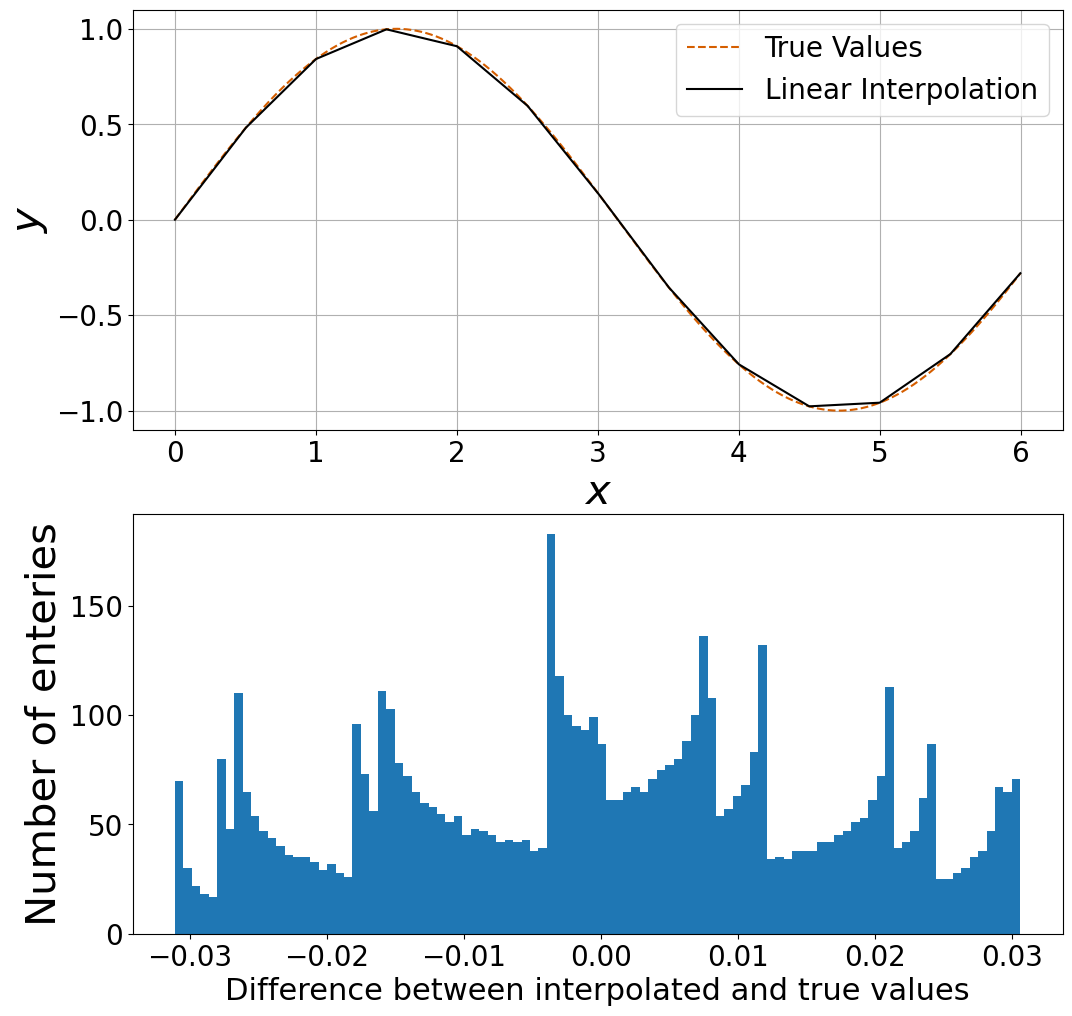

In [68]:
import numpy as np
import scipy as sp
import pylab as plt

X=np.arange(0, 6.5, 0.5) #We go to  6.5 to ensure that we get to 6
y=np.sin(X)

#Finer binned version for comparison
Xf=np.arange(0, 6, 0.001) 
yf=np.sin(Xf)


fig, axs= plt.subplots(2, figsize=(12, 12))

axs[0].plot(Xf, yf, "g--", label="True Values", color='#D55E00')
axs[0].set_xlabel("$x$", fontsize=30)
axs[0].set_ylabel("$y$", fontsize=30)
axs[0].tick_params(labelsize=20)
axs[0].grid()


#Linear 1D interpolation, where we are given the predicted values, f
f=np.interp(Xf, X, y)

# f is an array containing all predicted values of y for a given array of x values
axs[0].plot(Xf, f, label="Linear Interpolation", color='black')

axs[0].legend(loc="upper right", prop={'size': 20})


#Now lets histogram the difference
ydiff=yf-f
axs[1].hist(ydiff, bins=100)
axs[1].set_xlabel("Difference between interpolated and true values", fontsize=22)
axs[1].set_ylabel("Number of enteries", fontsize=30)
axs[1].tick_params(labelsize=20)
#plt.xlim([-0.04,0.04])

plt.show()

<div style="background-color:#efdff2">

As we can see here the differences are quite large, which can cause errors in predictions of data. There is also a structure in the differences. The interpolation struggles most where the graph is most curved (at the peak and trough) however does quite well at the points of maximum gradient. This could cause a systematic error in predicting future values

## Cubic Spline <a id='cs'></a>

A cubic spline uses a cubic polynomial between intervals which are chosen such that the successive cubics fit together smoothly. The resulting function is called a **spline**.The example below is identical to the previous one, except that instead of linear interpolation, a cubic spline has been employed.

To achieve this, we use the same `spi.interp1d` function, but specify the keyword argument `kind='cubic'`

/tmp/ipykernel_10153/2594655581.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  axs[0].plot(Xf, yf, "g--",label="True Values", color='#D55E00')


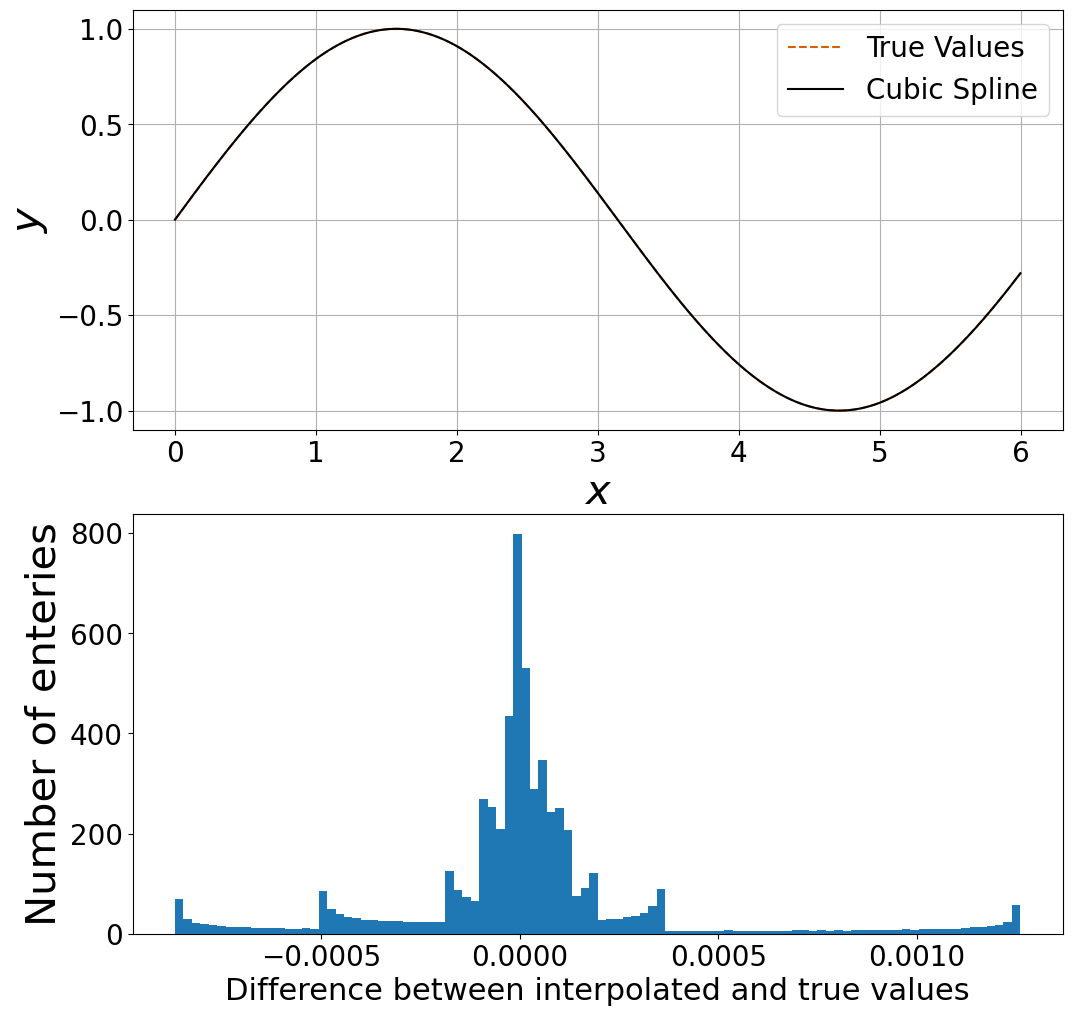

In [ ]:
import scipy.interpolate as spi

#Finer binned version for comparison
Xf=np.arange(0, 6, 0.001) 
yf=np.sin(Xf)

fig, axs= plt.subplots(2, figsize=(12, 12))

axs[0].plot(Xf, yf, "g--",label="True Values", color='#D55E00')
axs[0].set_xlabel("$x$", fontsize=30)
axs[0].set_ylabel("$y$", fontsize=30)
axs[0].tick_params(labelsize=20)
axs[0].grid()


#Linear 1D interpolation, where we are given the predicted values, f
f = spi.interp1d(X, y, kind='cubic')

# f is an array containing all predicted values of y for a given array of x values
axs[0].plot(Xf, f(Xf), label="Cubic Spline", color='black')

axs[0].legend(loc="upper right", prop={'size': 20})


#Now lets histogram the difference
ydiff=yf-f(Xf)
axs[1].hist(ydiff, bins=100)
axs[1].set_xlabel("Difference between interpolated and true values", fontsize=22)
axs[1].set_ylabel("Number of enteries", fontsize=30)
axs[1].tick_params(labelsize=20)
#plt.xlim([-0.04,0.04])

plt.show()

<div style="background-color:#efdff2">

Using a cubic spline as an approximation provides a much better fit (so much so that we can't really notice a difference at this scale), with significantly smaller differences between the interpolated and true values (notice that the x-axis scale is much smaller than in the linear example). However, even with this improved accuracy, there is still a *structure present in the error*, resulting in systematic biases (although these biases are smaller when the differences are small).
SciPy also implements two-dimensional forms of these interpolation algorithms.

It's important to note that while using a cubic spline is generally effective, it is not a foolproof solution. In cases where there aren't enough data points, the cubic spline can occasionally overestimate or underestimate the true curve (as shown in the example below). However, it is generally pretty good.

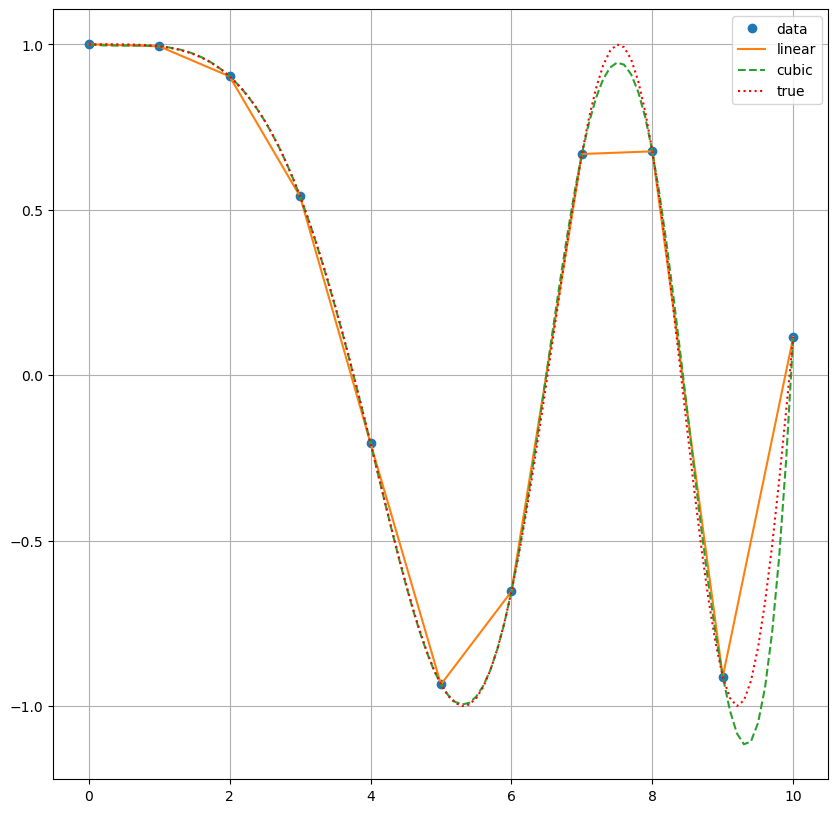

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10] 
Xn = np.linspace(0, 10, num=11, endpoint=True)
yn = np.cos(-Xn**2/9.0)
fn = spi.interp1d(Xn, yn)
fn2 = spi.interp1d(Xn, yn, kind='cubic')

Xnew = np.linspace(0, 10, num=101, endpoint=True)
import matplotlib.pyplot as plt
yt = np.cos(-Xnew**2/9.0)
plt.plot(Xn, yn, 'o', Xnew, fn(Xnew), '-', Xnew, fn2(Xnew), '--', Xnew, yt, 'r:')
plt.grid()
plt.legend(['data', 'linear', 'cubic','true'], loc='best')
plt.show()

<div style="background-color:#efdff2">

## Summary

In this section, you have been introduced to XYZ . This has included:

* XYZ
* XYZ
The next section will ABC.